In [1]:
from copy import deepcopy
import pandas as pd 
import numpy as np
import glob
from tqdm.notebook import tqdm
import cv2
import os
from sklearn.model_selection import train_test_split
import json

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.models import resnet18

from PIL import Image
from PIL.ExifTags import TAGS

import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
device = "cuda"

In [3]:
def _compute_metric(
    data_true_batch, data_pred_batch, w = 10496, h = 10496
):
    result_metric = 0
    for data_true, data_pred in zip(data_true_batch, data_pred_batch):
        x_center_true = data_true[0]
        y_center_true = data_true[1]
        x_center_pred = data_pred[0]
        y_center_pred = data_pred[1]


        x_metr = abs(x_center_true - x_center_pred)
        y_metr = abs(y_center_true - y_center_pred)
        angle_metr = abs(data_true[2] - data_pred[2])

        metr = 1 - (
            0.7 * 0.5 * (x_metr + y_metr) + 
            0.3 * min(angle_metr, abs(angle_metr - 360))
        )
        result_metric += metr
    return result_metric / (len(data_true_batch) + 1)

## Датасет


In [5]:
image = Image.open("../data/original.tiff")
exifdata = image.getexif()
tags = []
data = []
for tag_id in exifdata:
    # get the tag name, instead of human unreadable tag id
    tag = TAGS.get(tag_id, tag_id)
    data.append(exifdata.get(tag_id))
    # decode bytes 
    if isinstance(data[-1], bytes):
        data[-1] = data[-1].decode()
    tags.append(tag)
    # print(f"{tag:25}: {data}")

print("TAGS")
for tag in tags:
    print(tag)
print()

for tag, d in zip(tags, data):
    print(f"{tag:25}: {d}")

TAGS
ImageWidth
ImageLength
BitsPerSample
Compression
PhotometricInterpretation
StripOffsets
SampleFormat
SamplesPerPixel
RowsPerStrip
StripByteCounts
PlanarConfiguration
Predictor

ImageWidth               : 10496
ImageLength              : 10496
BitsPerSample            : (8, 8, 8)
Compression              : 5
PhotometricInterpretation: 2
StripOffsets             : (8, 24160, 48031, 71818, 95506, 118808, 142205, 165543, 189064, 212773, 236299, 259890, 283633, 307593, 331677, 355938, 380486, 404989, 429363, 453449, 477297, 501138, 524890, 548604, 572586, 596576, 620312, 644083, 667791, 691603, 715511, 739802, 764330, 788725, 812905, 836830, 860634, 884423, 908076, 931678, 955656, 979797, 1003675, 1027553, 1051340, 1075445, 1099507, 1123930, 1148620, 1173202, 1197501, 1221543, 1245405, 1269119, 1292865, 1316443, 1340175, 1363841, 1387385, 1410857, 1434184, 1457692, 1481265, 1505219, 1529245, 1553167, 1576716, 1600121, 1623488, 1646688, 1669883, 1692918, 1716216, 1739433, 1762399, 17855

In [6]:
print(image.size)
IMG_SIZE = image.size[0]

(10496, 10496)


In [7]:
from math import sin, cos

json_dir = "../data/train/json/"


data_df = pd.DataFrame({'id': [], "left_top_x": [], 'left_top_y': [], "right_bottom_x": [], 'right_bottom_y': [], 'angle': []})

json_true = []
rows = []
for _, _, files in os.walk(json_dir):
  for x in files:
    if x.endswith(".json"):
      data = json.load(open(json_dir + x))
      new_row = {
        'id':x.split(".")[0]+".png", 
        'left_top_x': data["left_top"][0] / IMG_SIZE, 
        'left_top_y': data["left_top"][1] / IMG_SIZE, 
        'right_bottom_x': data["right_bottom"][0] / IMG_SIZE, 
        "right_bottom_y": data["right_bottom"][1] / IMG_SIZE, 
        "x_center": (data["left_top"][0] + data["right_bottom"][0]) / 2 / IMG_SIZE,
        "y_center": (data["left_top"][1] + data["right_bottom"][1]) / 2 / IMG_SIZE,
        'angle': data["angle"] / 360
    }
      rows.append(new_row)

data_df = pd.DataFrame(rows)

In [8]:
data_df.head(5)

,id,left_top_x,left_top_y,right_bottom_x,right_bottom_y,x_center,y_center,angle
0,796.png,0.126048,0.257812,0.244284,0.328792,0.185166,0.293302,0.961111
1,319.png,0.207698,0.171970,0.100514,0.258765,0.154106,0.215368,0.266667
2,928.png,0.731898,0.802687,0.755812,0.938643,0.743855,0.870665,0.097222
3,1058.png,0.276200,0.938834,0.409489,0.903106,0.342845,0.920970,0.833333
4,344.png,0.409870,0.760957,0.539539,0.808117,0.474705,0.784537,0.930556


In [9]:
data_df.to_csv("../data/train.csv", index=False)

In [10]:
class ImageDataset(Dataset):
    def __init__(self, data_df, transform=None):

        self.data_df = data_df
        self.transform = transform

    def __getitem__(self, idx):
        # достаем имя изображения и ее лейбл
        image_name, labels = self.data_df.iloc[idx]['id'], [self.data_df.iloc[idx]['x_center'], self.data_df.iloc[idx]['y_center'], self.data_df.iloc[idx]['angle']]

        # читаем картинку. read the image
        image = cv2.imread(f"../data/train/img/{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # преобразуем, если нужно. transform it, if necessary
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(labels).float()
    
    def __len__(self):
        return len(self.data_df)

In [11]:
# задаем преобразование изображения.

train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

valid_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

In [12]:
# читаем датасет
data_df = pd.read_csv("../data/train.csv")

In [13]:
from os import listdir

print("Обучающей выборки " ,len(listdir("../data/train/img")))
print("Тестовой выборки " ,len(listdir("../data/test")))

Обучающей выборки  800
Тестовой выборки  400


In [14]:
# разделим датасет на трейн и валидацию, чтобы смотреть на качество
train_df, valid_df = train_test_split(data_df, test_size=0.2, random_state=42)

In [15]:
train_df.shape, valid_df.shape

((640, 8), (160, 8))

In [16]:
train_dataset = ImageDataset(train_df, train_transform)
valid_dataset = ImageDataset(valid_df, valid_transform)

In [17]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=4)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=64,
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=4)

## Вспомогательные функции

In [18]:
# def crossvalid(res_model=None, criterion=None, optimizer=None, dataset=None, k_fold=5):
    
#     train_score = pd.Series()
#     val_score = pd.Series()
    
#     total_size = len(dataset)
#     fraction = 1 / k_fold
#     seg = int(total_size * fraction)
#     # tr:train,val:valid; r:right,l:left;  eg: trrr: right index of right side train subset 
#     # index: [trll,trlr],[vall,valr],[trrl,trrr]
#     for i in range(k_fold):
#         trll = 0
#         trlr = i * seg
#         vall = trlr
#         valr = i * seg + seg
#         trrl = valr
#         trrr = total_size
        
#         train_left_indices = list(range(trll,trlr))
#         train_right_indices = list(range(trrl,trrr))
        
#         train_indices = train_left_indices + train_right_indices
#         val_indices = list(range(vall,valr))
        
#         train_set = torch.utils.data.dataset.Subset(dataset,train_indices)
#         val_set = torch.utils.data.dataset.Subset(dataset,val_indices)
        
#         train_loader = torch.utils.data.DataLoader(train_set, batch_size=50,
#                                           shuffle=True, num_workers=4)
#         val_loader = torch.utils.data.DataLoader(val_set, batch_size=50,
#                                           shuffle=True, num_workers=4)
#         train_acc = train(res_model,criterion,optimizer,train_loader,val_loader,1)
#         train_score.at[i] = train_acc
#         #val_acc = valid(res_model,criterion,optimizer,val_loader)
#         #val_score.at[i] = val_acc
    
#     return train_score,val_score

In [19]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [20]:
def train(model, criterion, optimizer, scheduler, train_dataloader, test_dataloader, NUM_EPOCH=15):
    train_loss_log = []
    val_loss_log = []
    train_metrics = []
    val_metrics = []
    best_loss = np.inf
        
    for epoch in tqdm(range(NUM_EPOCH)):
        model.train()
        train_loss = 0.
        train_size = 0
        
        train_pred = 0.

        for imgs, labels in train_dataloader:
            optimizer.zero_grad()

            imgs = imgs.to(device)
            labels = labels.to(device)

            y_pred = model(imgs)

            loss = criterion(y_pred, labels)
            loss.backward()
            
            train_loss += loss.item()
            train_size += y_pred.size(0)
            train_loss_log.append((loss.data / y_pred.size(0)).item())
            
            # train_metrics.append(_compute_metric(labels.detach().cpu().tolist(), y_pred.detach().cpu().tolist()))

            optimizer.step()

        val_loss = 0.
        val_size = 0
        
        val_pred = 0.
        
        model.eval()
        
        with torch.no_grad():
            for imgs, labels in test_dataloader:
                
                imgs = imgs.to(device)
                labels = labels.to(device)
                
                pred = model(imgs)
                loss = criterion(pred, labels)
                
                val_loss += loss.item()
                val_size += pred.size(0)
                
                val_pred += (pred == labels).sum()
        
        val_loss_log.append(val_loss / val_size)
        val_metrics.append(_compute_metric(labels.cpu().tolist(), sigmoid(pred).cpu().tolist()))

        scheduler.step(loss)

        if val_loss_log[-1] < best_loss:
            best_loss = val_loss_log[-1]
            best_model = deepcopy(model)
            torch.save(best_model.state_dict(), "best.pth")

        clear_output()
        plot_history(train_loss_log, val_loss_log, 'loss')

        print('Train loss:', (train_loss / train_size) * 100)
        print('Val loss:', (val_loss / val_size) * 100)
        # print('Train score:', np.mean(train_metrics))
        print('Last Val score:', val_metrics[-1])
        print('Best Val score:', max(val_metrics))
    return best_model, train_loss_log, val_loss_log

## Модель

In [25]:
torch.cuda.empty_cache()

In [26]:
# Подргружаем модель

model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
model.fc = nn.Linear(model.fc.in_features, 3)

model = model.to(device)
criterion = torch.nn.MSELoss()
sigmoid = torch.nn.Sigmoid()

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=5, verbose=True)

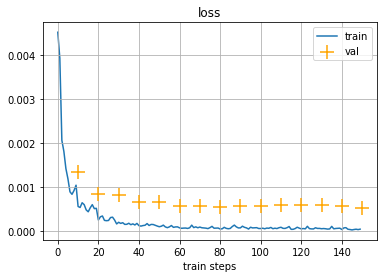

Train loss: 0.00393879039620515
Val loss: 0.05308762425556779
Last Val score: 0.7899100707357073
Best Val score: 0.793260718297185


In [28]:
best_model, train_loss_log, val_loss_log = train(
    model, 
    criterion, 
    optimizer, 
    scheduler,
    train_loader, 
    valid_loader, 
    15
)

## Посчитаем метрику

In [29]:
def compute_metric(
    data_true_batch, data_pred_batch, w = 10496, h = 10496
):
    result_metric = 0
    for data_true, data_pred in zip(data_true_batch, data_pred_batch):
        x_center_true = int((data_true["left_top_x"] + data_true["right_bottom_x"]) / 2)
        y_center_true = int((data_true["left_top_y"] + data_true["right_bottom_y"]) / 2)
        x_center_pred = int((data_pred["left_top_x"] + data_pred["right_bottom_x"]) / 2)
        y_center_pred = int((data_pred["left_top_y"] + data_pred["right_bottom_y"]) / 2)


        x_metr = abs(x_center_true - x_center_pred)
        y_metr = abs(y_center_true - y_center_pred)
        angle_metr = abs(data_true["angle"] - data_pred["angle"])

        metr = 1 - (
            0.7 * 0.5 * (x_metr + y_metr) + 
            0.3 * min(angle_metr, abs(angle_metr - 360))
        )
        result_metric += metr
    return result_metric / (len(data_true_batch) + 1)

In [31]:
preds = []
gt = []
with torch.no_grad():
    for imgs, labels in valid_loader:
        
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        pred = sigmoid(best_model(imgs))
        
        preds.extend(pred.cpu().tolist())
        gt.extend(labels.cpu().tolist())


In [32]:
_compute_metric(gt, preds)

0.7968151234754111